<a href="https://colab.research.google.com/github/MrezaFd/Tugas-Besar-ML-059-055-/blob/main/Tugas_7_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import files #import lib
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"radityajs28","key":"c68d62e8c60d5e8e868437c6f9256a81"}'}

In [3]:
!mkdir -p ~/.kaggle #membuat directory bernama kaggle 
!cp kaggle.json ~/.kaggle/ #copy file kaggle.json upload tadi ke directory baru
!chmod 600 ~/.kaggle/kaggle.json #berikan izin untuk file kaggle.jsonv

In [4]:
#Unduh dataset
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 97% 314M/325M [00:06<00:00, 75.0MB/s]
100% 325M/325M [00:06<00:00, 55.0MB/s]


In [6]:
from zipfile import ZipFile
file_name = "skin-cancer-malignant-vs-benign.zip"

with ZipFile(file_name,'r') as zip :
  zip.extractall()
  print('Berhasil')

Berhasil


In [7]:
!mkdir a

In [8]:
!mv -t a test train

In [9]:
# Definisikan path untuk data train dan data validation
import os
base_dir = '/content/a'


train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

In [10]:
import cv2
import numpy as np

# Gather data train
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

In [11]:
# Gather data validation
val_data = []
val_label = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)

val_data = np.array(val_data)
val_label = np.array(val_label)

In [12]:
# Tampilkan shape dari data train dan data validation
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (2637, 150, 150, 3)
Train Label =  (2637,)
Validation Data =  (660, 150, 150, 3)
Validation Label =  (660,)


In [13]:
# Normalisasi dataset
print("Data sebelum di-normalisasi ", train_data[0][0][0])

x_train = train_data.astype('float32') / 255.0
x_val = val_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_train[0][0][0])

Data sebelum di-normalisasi  [22 12 29]
Data setelah di-normalisasi  [0.08627451 0.04705882 0.11372549]


In [14]:
# Transformasi label encoder
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", train_label[995:2005])

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_val = lb.fit_transform(val_label)

print("Label setelah di-encoder ", y_train[995:2005])

Label sebelum di-encoder  ['malignant' 'malignant' 'malignant' ... 'benign' 'benign' 'benign']
Label setelah di-encoder  [1 1 1 ... 0 0 0]


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [16]:
# Feature Extraction Layer
model = Sequential()

model.add(InputLayer(input_shape=[150,150,3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Flatten())

In [17]:
# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [18]:
# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 64)       0

In [19]:
best_model_cancer_path = 'model-cancer.h5'
checkpoint_callback = ModelCheckpoint(best_model_cancer_path,
                                     monitor='val_acc',
                                     save_best_only=True,
                                     verbose=1)
callbacks_list = [checkpoint_callback]

In [20]:
# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
H = model.fit(x_train, y_train, batch_size=20, epochs=25, validation_data=(x_val, y_val))

Epoch 1/25
132/132 [==============================] - 60s 445ms/step - loss: 0.5847 - acc: 0.6871 - val_loss: 0.5109 - val_acc: 0.7167
Epoch 2/25
132/132 [==============================] - 59s 444ms/step - loss: 0.4524 - acc: 0.7679 - val_loss: 0.4051 - val_acc: 0.7879
Epoch 3/25
132/132 [==============================] - 58s 443ms/step - loss: 0.4236 - acc: 0.7941 - val_loss: 0.4057 - val_acc: 0.7985
Epoch 4/25
132/132 [==============================] - 58s 443ms/step - loss: 0.4020 - acc: 0.8055 - val_loss: 0.4264 - val_acc: 0.7909
Epoch 5/25
132/132 [==============================] - 58s 441ms/step - loss: 0.3756 - acc: 0.8123 - val_loss: 0.3344 - val_acc: 0.8288
Epoch 6/25
132/132 [==============================] - 58s 442ms/step - loss: 0.3280 - acc: 0.8415 - val_loss: 0.3668 - val_acc: 0.8091
Epoch 7/25
132/132 [==============================] - 58s 442ms/step - loss: 0.3101 - acc: 0.8570 - val_loss: 0.3374 - val_acc: 0.8379
Epoch 8/25
132/132 [==============================] - 5

In [22]:
model.save_weights('model-cancer.h5')

In [23]:
model.get_weights()

[array([[[[ 7.70905316e-02,  1.29209965e-01,  2.23758742e-01,
           -2.01857295e-02,  2.16384262e-01,  1.02150448e-01,
            6.63038343e-02,  9.42493379e-02,  1.07407019e-01,
           -7.33551458e-02, -1.45518273e-01,  1.34346575e-01,
            1.53587073e-01,  1.64419845e-01, -6.86876401e-02,
           -1.86350361e-01],
          [ 1.59484893e-01,  1.17437258e-01,  3.31883505e-02,
           -9.42189470e-02, -9.83983651e-02, -1.14258014e-01,
           -1.16820656e-01, -1.96005553e-01,  1.07260302e-01,
            1.05681019e-02,  2.44445652e-02,  2.12877318e-01,
           -5.32258414e-02, -1.63244382e-01,  2.73938850e-02,
            2.08795935e-01],
          [ 1.47330901e-02, -1.60998985e-01, -9.51431841e-02,
           -8.97213966e-02,  7.72509053e-02,  9.39257592e-02,
            1.29643008e-01,  1.53477311e-01,  4.12237123e-02,
           -6.00412525e-02, -1.45365506e-01,  7.16563389e-02,
            6.69955015e-02, -1.00065053e-01, -1.95716113e-01,
            

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

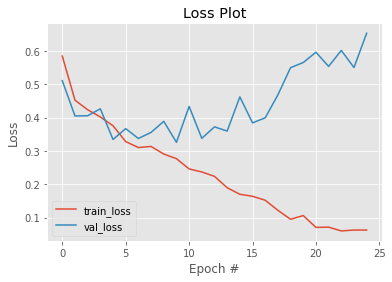

<Figure size 432x288 with 0 Axes>

In [25]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.savefig('loss-plot-cancer.png')

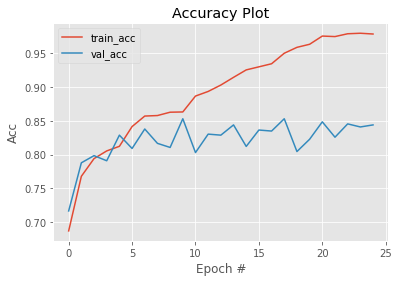

<Figure size 432x288 with 0 Axes>

In [26]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 25), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

plt.savefig('accuracy-plot-cancer.png')

In [27]:
from sklearn.metrics import classification_report

pred = model.predict(x_val)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_val, labels))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       360
           1       0.84      0.81      0.82       300

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660

